In [1]:
from tools import make_cases

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
cases = make_cases('court_cases_sample/success/')

In [3]:
df_cases = pd.DataFrame(cases)
df_accounts = pd.read_csv('df_accounts_sample.csv', index_col=0)
df_bankruptcies = pd.read_csv('df_bankruptcies_sample.csv', index_col=0)

In [4]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8449 entries, 0 to 8448
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   inn           8449 non-null   int64 
 1   resultType    8449 non-null   object
 2   caseNo        8449 non-null   object
 3   caseDate      8449 non-null   object
 4   instanceDate  8449 non-null   object
 5   caseType      8449 non-null   object
 6   sum           8449 non-null   object
 7   type          8449 non-null   object
dtypes: int64(1), object(7)
memory usage: 528.2+ KB


In [5]:
df_accounts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   inn                                 1035 non-null   int64  
 1   year                                1035 non-null   int64  
 2   long_term_liabilities_fiscal_year   960 non-null    float64
 3   short_term_liabilities_fiscal_year  1035 non-null   int64  
 4   balance_assets_fiscal_year          1035 non-null   int64  
 5   okei                                1035 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 56.6 KB


In [6]:
df_bankruptcies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 105
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   bankrupt_id    106 non-null    int64
 1   bancrupt_year  106 non-null    int64
 2   inn            106 non-null    int64
dtypes: int64(3)
memory usage: 3.3 KB


In [7]:
df_cases.head()

,inn,resultType,caseNo,caseDate,instanceDate,caseType,sum,type
0,5414100369,Не удалось определить,А45-919/2017,2017-01-23T00:00:00,2017-01-24T00:00:00,5,18615950.0,0
1,5414100369,Проиграно,А45-11656/2016,2016-06-06T00:00:00,2016-10-13T00:00:00,6,175795.31,1
2,5414100369,Проиграно,А45-23060/2015,2015-11-02T00:00:00,2018-11-08T05:44:31,1,194788.98,1
3,1508000122,Не удалось определить,А61-1415/2020,2020-05-18T00:00:00,2020-09-23T18:18:09,6,0.0,1
4,1508000122,Не выиграно,А61-3399/2019,2019-07-12T00:00:00,2019-12-27T00:00:00,5,0.0,0


In [8]:
df_accounts.head()

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
0,2465002653,2012,0.0,113756,122240,384
1,3505003270,2012,21461.0,20211,81132,384
2,3517003250,2012,0.0,0,48063,384
3,5501078737,2012,0.0,288763,419522,384
4,6140019517,2012,0.0,0,11089,384


In [9]:
df_bankruptcies.head()

,bankrupt_id,bancrupt_year,inn
0,79546,2015,5620006322
1,76594,2015,2111008200
2,94301,2016,5414100369
3,93799,2019,2347009476
4,199671,2018,7224008489


In [10]:
df_cases.shape, df_accounts.shape, df_bankruptcies.shape

((8449, 8), (1035, 6), (106, 3))

Конкретная дата каждого иска и судебного процесса не так важна для дальнейшего анализа. Поэтому извлечем значение года.

In [11]:
df_cases['caseDate'] = pd.to_datetime(df_cases['caseDate'], errors='coerce')
df_cases['instanceDate'] = pd.to_datetime(df_cases['instanceDate'], errors='coerce')

df_cases['caseYear'] = df_cases['caseDate'].apply(lambda x: x.year)
df_cases['instanceYear'] = df_cases['instanceDate'].apply(lambda x: x.year)

df_cases.drop(['caseDate', 'instanceDate'], axis=1, inplace=True)

В датасете с бухгалтерскими данными приведем все к одной размерности.

In [12]:
cols = [col for col in df_accounts.columns if '_year' in col]
df_accounts.loc[df_accounts['okei'] == 384, cols] = df_accounts * 1000
df_accounts.drop('okei', axis=1, inplace=True)

Создадим датафрейм, который будем наполнять по ходу рассуждений. Его же будем использовать для построения модели в будущем.

In [13]:
df = pd.DataFrame({'inn': np.sort(df_accounts['inn'].unique())})
df['is_bankrupt'] = 0
df['bancrupt_year'] = 0

In [14]:
df.head()

,inn,is_bankrupt,bancrupt_year
0,1001003743,0,0
1,1020010136,0,0
2,1203000142,0,0
3,1302000640,0,0
4,1411004211,0,0


Если какие-то ИНН есть в датафрейме с обокротившимися организациями, то установим значение "is_bankrupt" в 1.

In [15]:
df.loc[df['inn'].isin(df_bankruptcies['inn'].unique()), 'is_bankrupt'] = 1
df.head()

,inn,is_bankrupt,bancrupt_year
0,1001003743,0,0
1,1020010136,1,0
2,1203000142,1,0
3,1302000640,1,0
4,1411004211,1,0


И для каждой обонкротившейся организации зафиксируем год банкротства.

In [16]:
df.loc[df['inn'].isin(df_bankruptcies['inn'].unique()), 'bancrupt_year'] = df_bankruptcies['bancrupt_year']

In [17]:
df.head()

,inn,is_bankrupt,bancrupt_year
0,1001003743,0,0.0
1,1020010136,1,2015.0
2,1203000142,1,2016.0
3,1302000640,1,2019.0
4,1411004211,1,2018.0


В судебных данных есть организации, которых нет в бухгалтерских данных. Нет смысла предсказывать банкротство только по судебным данным, поэтому уберим такие организации из датасета.

In [18]:
len(set(df_cases['inn']) - set(df['inn'])) > 0

True

In [19]:
df_cases = df_cases[df_cases['inn'].isin(df['inn'])]

Т.к. наша задача - предсказать вероятность банкроства, то будем рассматривать данные за время до банкротства. Будем делать так с судебными и бухгалтерскими данными. В случае судебных данных мы будем смотреть на всю доступную "историю" до года банкроства включительно. В случае бухгалтерских данных отберем записи за год банкроства, а если таких нет, то за последний известный год. 

In [20]:
merged_cases = df_cases.merge(df, on='inn')

In [21]:
merged_cases = merged_cases[~((merged_cases['is_bankrupt'] == 1) & (merged_cases['instanceYear'] > merged_cases['bancrupt_year']))]

In [22]:
merged_cases.head()

,inn,resultType,caseNo,caseType,sum,type,caseYear,instanceYear,is_bankrupt,bancrupt_year
0,5414100369,Не удалось определить,А45-919/2017,5,18615950.0,0,2017.0,2017.0,1,2019.0
1,5414100369,Проиграно,А45-11656/2016,6,175795.31,1,2016.0,2016.0,1,2019.0
2,5414100369,Проиграно,А45-23060/2015,1,194788.98,1,2015.0,2018.0,1,2019.0
3,1508000122,Не удалось определить,А61-1415/2020,6,0.0,1,2020.0,2020.0,1,2021.0
4,1508000122,Не выиграно,А61-3399/2019,5,0.0,0,2019.0,2019.0,1,2021.0


Далее отдельно для каждой организации будем смотреть на то, в скольких судебных процессах каждого вида она участвовала, сколько результатов каждого вида по искам она получила, и сколько раз в и в какой роли она участвовала в судебных процессах.

In [23]:
result_type_pivot = pd.pivot_table(data=merged_cases,
                                   values='caseNo',
                                   index='inn',
                                   columns=['resultType'],
                                   aggfunc=pd.Series.nunique,
                                   fill_value=0)

In [24]:
result_type_pivot.head()

resultType,В иске отказано полностью,В иске отказано частично,Выиграно,Иск не рассмотрен,Иск полностью удовлетворен,Иск частично удовлетворен,"Иск частично удовлетворен, встречный не удовлетворен",Не выиграно,Не проиграно,Не удалось определить,Прекращено производство по делу,Проиграно,Утверждено мировое соглашение,Частично выиграно,Частично проиграно
inn,,,,,,,,,,,,,,,
1001003743,0,0,1,0,0,0,0,0,0,2,0,0,0,1,0
1203000142,2,0,12,0,5,1,0,3,9,136,0,7,0,7,7
1302000640,0,0,0,0,0,0,0,0,0,7,0,2,0,0,0
1411004211,0,0,0,0,1,0,0,0,0,4,0,9,0,0,2
1429006530,1,0,0,1,1,0,0,0,1,10,0,15,0,0,3


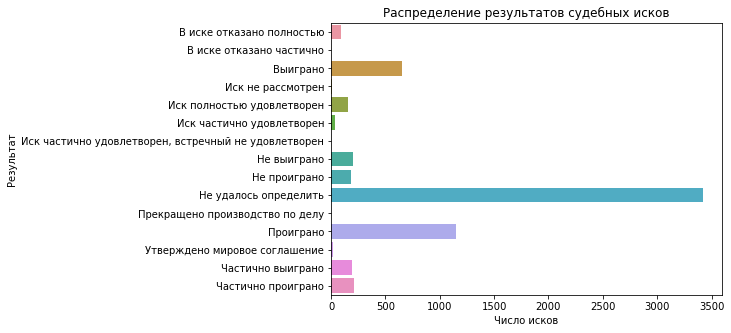

In [25]:
plt.figure(figsize=(7, 5))
sns.barplot(x=result_type_pivot.sum().values, y=result_type_pivot.sum().index)
plt.title('Распределение результатов судебных исков')
plt.xlabel('Число исков')
plt.ylabel('Результат')
plt.show()

In [26]:
to_rename = {
    'В иске отказано полностью': 'completely_denied',
    'В иске отказано частично': 'partially_denied',
    'Выиграно': 'won',
    'Иск не рассмотрен': 'not_considered',
    'Иск полностью удовлетворен': 'fully_satisfied',
    'Иск частично удовлетворен': 'partially_satisfied',
    'Иск частично удовлетворен, встречный не удовлетворен': 'partially_satisfied_counterclaim_not',
    'Не выиграно': 'not_won',
    'Не проиграно': 'not_lost',
    'Не удалось определить': 'couldnt_determine',
    'Прекращено производство по делу': 'case_were_terminated',
    'Проиграно': 'lost',
    'Утверждено мировое соглашение': 'settlement_agreement',
    'Частично выиграно': 'partially_won',
    'Частично проиграно': 'partially_lost'
}

result_type_pivot.rename(columns=to_rename, inplace=True)

In [27]:
result_type_pivot.head()

resultType,completely_denied,partially_denied,won,not_considered,fully_satisfied,partially_satisfied,partially_satisfied_counterclaim_not,not_won,not_lost,couldnt_determine,case_were_terminated,lost,settlement_agreement,partially_won,partially_lost
inn,,,,,,,,,,,,,,,
1001003743,0,0,1,0,0,0,0,0,0,2,0,0,0,1,0
1203000142,2,0,12,0,5,1,0,3,9,136,0,7,0,7,7
1302000640,0,0,0,0,0,0,0,0,0,7,0,2,0,0,0
1411004211,0,0,0,0,1,0,0,0,0,4,0,9,0,0,2
1429006530,1,0,0,1,1,0,0,0,1,10,0,15,0,0,3


In [28]:
case_type_pivot = pd.pivot_table(data=merged_cases,
                                 values='caseNo',
                                 index='inn',
                                 columns=['caseType'],
                                 aggfunc=pd.Series.nunique,
                                 fill_value=0)

In [29]:
case_type_pivot.head()

caseType,1,3,4,5,6,73,90
inn,,,,,,,
1001003743,0,0,0,2,2,0,0
1203000142,7,0,0,80,98,0,2
1302000640,2,0,0,3,4,0,0
1411004211,2,0,0,0,14,0,0
1429006530,0,0,0,1,31,0,0


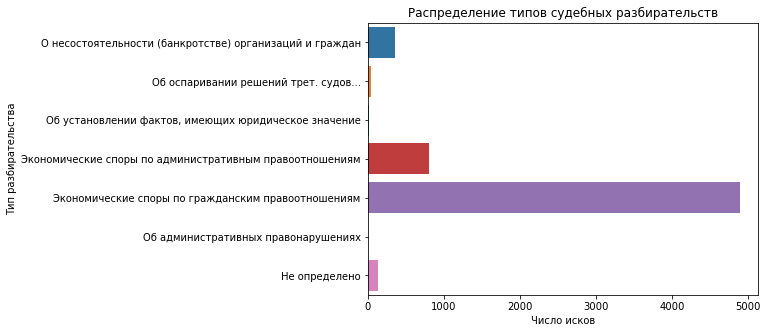

In [30]:
plt.figure(figsize=(7, 5))
g = sns.barplot(x=case_type_pivot.sum().values, y=case_type_pivot.sum().index)
plt.title('Распределение типов судебных разбирательств')
plt.xlabel('Число исков')
plt.ylabel('Тип разбирательства')
ticks = [
    'О несостоятельности (банкротстве) организаций и граждан',
    'Об оспаривании решений трет. судов...',
    'Об установлении фактов, имеющих юридическое значение',
    'Экономические споры по административным правоотношениям',
    'Экономические споры по гражданским правоотношениям',
    'Об административных правонарушениях',
    'Не определено'
]
g.set_yticklabels(ticks)
plt.show()

In [31]:
case_type_pivot = case_type_pivot.add_prefix('case_type_')

In [32]:
side_type_pivot = pd.pivot_table(data=merged_cases,
                                 values='caseNo',
                                 index='inn',
                                 columns=['type'],
                                 aggfunc=pd.Series.nunique, 
                                 fill_value=0)

In [33]:
side_type_pivot.head()

type,0,1,2,3
inn,,,,
1001003743,4,0,0,0
1203000142,90,86,13,4
1302000640,3,6,0,0
1411004211,1,15,1,0
1429006530,0,29,1,2


In [34]:
side_type_pivot = side_type_pivot.add_prefix('side_type_')

In [35]:
for table in [result_type_pivot, case_type_pivot, side_type_pivot]:
    table.reset_index(inplace=True)
    table.columns.name = None

In [36]:
side_type_pivot.head()

,inn,side_type_0,side_type_1,side_type_2,side_type_3
0,1001003743,4,0,0,0
1,1203000142,90,86,13,4
2,1302000640,3,6,0,0
3,1411004211,1,15,1,0
4,1429006530,0,29,1,2


In [37]:
result_df_by_cases = result_type_pivot.merge(case_type_pivot, on='inn') \
    .merge(side_type_pivot, on='inn')

In [38]:
result_df_by_cases.head()

,inn,completely_denied,partially_denied,won,not_considered,fully_satisfied,partially_satisfied,partially_satisfied_counterclaim_not,not_won,not_lost,...,case_type_3,case_type_4,case_type_5,case_type_6,case_type_73,case_type_90,side_type_0,side_type_1,side_type_2,side_type_3
0,1001003743,0,0,1,0,0,0,0,0,0,...,0,0,2,2,0,0,4,0,0,0
1,1203000142,2,0,12,0,5,1,0,3,9,...,0,0,80,98,0,2,90,86,13,4
2,1302000640,0,0,0,0,0,0,0,0,0,...,0,0,3,4,0,0,3,6,0,0
3,1411004211,0,0,0,0,1,0,0,0,0,...,0,0,0,14,0,0,1,15,1,0
4,1429006530,1,0,0,1,1,0,0,0,1,...,0,0,1,31,0,0,0,29,1,2


In [39]:
df = df[df['inn'].isin(result_df_by_cases['inn'].unique())]

In [40]:
df_accounts = df_accounts[df_accounts['inn'].isin(result_df_by_cases['inn'].unique())]

Теперь займемся бухглатерскими данными

In [41]:
merged_accounts = df_accounts.merge(df, on='inn')

In [42]:
merged_accounts.head()

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,is_bankrupt,bancrupt_year
0,2465002653,2012,0.0,113756000,122240000,1,2014.0
1,2465002653,2013,0.0,212584000,241577000,1,2014.0
2,2465002653,2017,0.0,51779000,76710000,1,2014.0
3,2465002653,2014,0.0,63670000,95167000,1,2014.0
4,2465002653,2015,0.0,25896000,52292000,1,2014.0


In [43]:
merged_accounts = merged_accounts[~((merged_accounts['is_bankrupt'] == 1) & (merged_accounts['year'] > merged_accounts['bancrupt_year']))]

In [44]:
merged_accounts = merged_accounts.drop_duplicates(subset='inn', keep='last')
merged_accounts.head()

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,is_bankrupt,bancrupt_year
3,2465002653,2014,0.0,63670000,95167000,1,2014.0
17,3505003270,2020,138870000.0,27978000,300065000,0,0.0
29,5501078737,2019,0.0,318900000,119616000,1,2019.0
39,6140019517,2020,1695000.0,618000,1650000,0,0.0
45,6105002983,2018,0.0,15405000,1325000,1,2020.0


In [45]:
merged_accounts.shape

(155, 7)

In [46]:
merged_accounts.sort_values('inn', inplace=True)
merged_accounts.reset_index(inplace=True)
merged_accounts.drop('index', axis=1, inplace=True)

In [47]:
merged_accounts.head()

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,is_bankrupt,bancrupt_year
0,1001003743,2019,NaN,4330000,3930000,0,0.0
1,1302000640,2014,3698000.0,22189000,25918000,1,2019.0
2,1411004211,2016,59514000.0,42477000,146980000,1,2018.0
3,1429006530,2016,0.0,106562000,236501000,1,2017.0
4,1435087440,2018,831000.0,758000,5917000,0,0.0


In [48]:
result_df_by_cases = result_df_by_cases[result_df_by_cases['inn'].isin(merged_accounts['inn'])]
df = df[df['inn'].isin(merged_accounts['inn'])]

In [49]:
result_df_by_cases.shape, df.shape, merged_accounts.shape

((155, 27), (155, 3), (155, 7))

In [50]:
cols = ['inn', 'long_term_liabilities_fiscal_year', 'short_term_liabilities_fiscal_year', 'balance_assets_fiscal_year']
merged_accounts = merged_accounts[cols]

In [51]:
merged_accounts.head()

,inn,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year
0,1001003743,NaN,4330000,3930000
1,1302000640,3698000.0,22189000,25918000
2,1411004211,59514000.0,42477000,146980000
3,1429006530,0.0,106562000,236501000
4,1435087440,831000.0,758000,5917000


После чистки и преобразования объединим все имеющиеся нужные таблицы в одну

In [52]:
df = df.merge(result_df_by_cases, on='inn').merge(merged_accounts, on='inn')

In [53]:
df.drop('bancrupt_year', axis=1, inplace=True)

In [54]:
df.head()

,inn,is_bankrupt,completely_denied,partially_denied,won,not_considered,fully_satisfied,partially_satisfied,partially_satisfied_counterclaim_not,not_won,...,case_type_6,case_type_73,case_type_90,side_type_0,side_type_1,side_type_2,side_type_3,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year
0,1001003743,0,0,0,1,0,0,0,0,0,...,2,0,0,4,0,0,0,NaN,4330000,3930000
1,1302000640,1,0,0,0,0,0,0,0,0,...,4,0,0,3,6,0,0,3698000.0,22189000,25918000
2,1411004211,1,0,0,0,0,1,0,0,0,...,14,0,0,1,15,1,0,59514000.0,42477000,146980000
3,1429006530,1,1,0,0,1,1,0,0,0,...,31,0,0,0,29,1,2,0.0,106562000,236501000
4,1435087440,0,0,0,1,0,0,0,0,0,...,5,0,0,8,4,0,0,831000.0,758000,5917000


In [55]:
df.isna().sum()

inn                                      0
is_bankrupt                              0
completely_denied                        0
partially_denied                         0
won                                      0
not_considered                           0
fully_satisfied                          0
partially_satisfied                      0
partially_satisfied_counterclaim_not     0
not_won                                  0
not_lost                                 0
couldnt_determine                        0
case_were_terminated                     0
lost                                     0
settlement_agreement                     0
partially_won                            0
partially_lost                           0
case_type_1                              0
case_type_3                              0
case_type_4                              0
case_type_5                              0
case_type_6                              0
case_type_73                             0
case_type_9

Видим, что в одной колонке есть пропуски. Заменим их на очень маленькое число, чтобы будущая модель обращала на них внимание.

In [56]:
df['long_term_liabilities_fiscal_year'].max()

9842836000.0

In [57]:
df['long_term_liabilities_fiscal_year'].fillna(-9999999999, inplace=True)

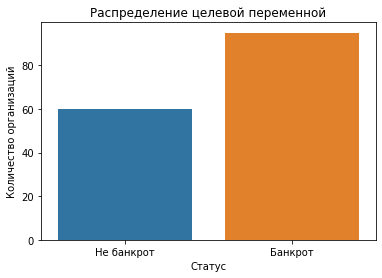

In [58]:
plt.figure()
g = sns.countplot(data=df, x='is_bankrupt')
plt.title('Распределение целевой переменной')
plt.xlabel('Статус')
plt.ylabel('Количество организаций')
g.set_xticklabels(['Не банкрот', 'Банкрот'])
plt.show()

Перед тем, как приступить к обучению модели, определимся с метриками, по которым будем оценивать качество предсказаний модели.

* Будем использовать recall метрику, чтобы увидеть, насколько хорошо модель вообще обнаруживает банкротство.
* В зависимости от требований бизнеса нужно будет устанавливать тот или иной порог вероятности, при котором организация будет считаться банкротом. Для наглядности результатов таких порогов построим ROC кривую.

In [59]:
X = df.drop(['inn', 'is_bankrupt'], axis=1)
y = df['is_bankrupt']

In [60]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [61]:
logreg = LogisticRegression(random_state=17)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=17)

In [63]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=17)

In [64]:
print(f'Recall before cross-validation on test data: {recall_score(y_test, logreg.predict(X_test))}')

Recall before cross-validation on test data: 0.8148148148148148


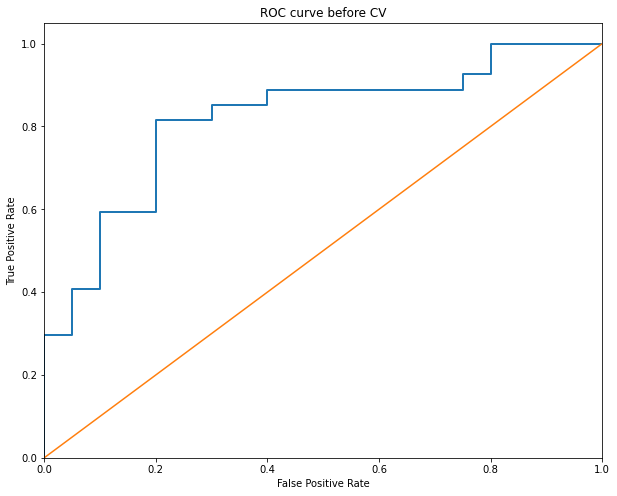

In [65]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve before CV')
plt.show()

In [66]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [67]:
logreg_cv = LogisticRegressionCV(Cs=np.logspace(-4, 4), 
                                 cv=skf,
                                 max_iter=1000,
                                 n_jobs=-1, 
                                 random_state=17)

In [68]:
logreg_cv.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.68511374e-02, 1.26485522e-01,
       1.84206997e-01, 2.68...
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     max_iter=1000, n_jobs=-1, random_state=17)

In [69]:
print(f'Recall after cross-validation on test data: {recall_score(y_test, logreg_cv.predict(X_test))}')

Recall after cross-validation on test data: 0.8518518518518519


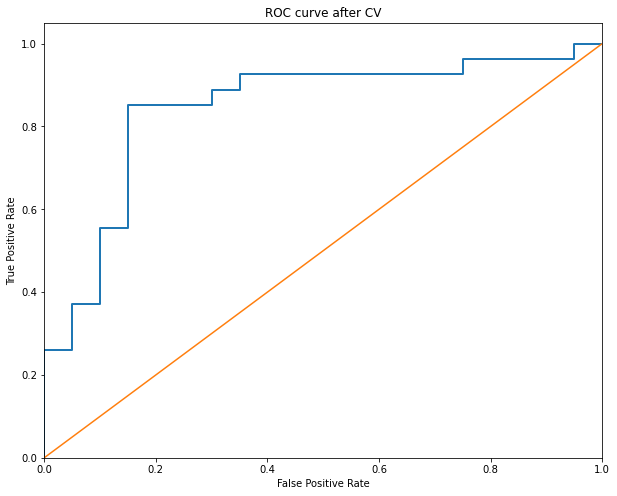

In [70]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, logreg_cv.predict_proba(X_test)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve after CV')
plt.show()

Получили неплохой бейслайн для предсказания банкротсва. Есть несколько способо получить результат лучше имющегося:

* Более глубокий подход к анализу данных, а также к формированию датасета для обучения.
* Использование другой модели и/или ансамбля моделей.